# Задание № 5.2
# АА тест контрольной и экспериментальной групп

In [1]:
# импортируем библиотеки
import pandahouse
from scipy import stats # Статистика
import seaborn as sns
from scipy.stats import levene # тест Левена
import pingouin as pg
import numpy as np

# Загружаем данные для анализа

In [28]:
# указываем параметры подключения к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [29]:
# составляем запрос к данным в БД

q = """

SELECT DISTINCT exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

In [30]:
# вызываем запрос и сохраняем в df полученные данные
df = pandahouse.read_clickhouse(q, connection=connection)

# Первичная оценка данных

Для начала оценим на распределения ctr в группах визуально

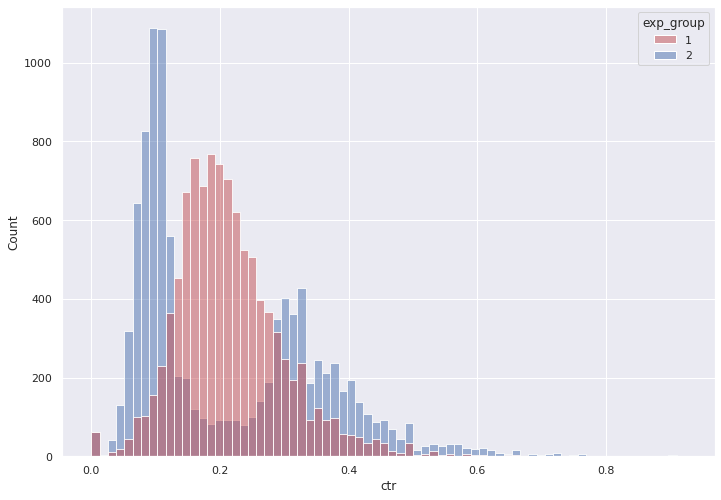

In [5]:
# увеличили размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Значение ctr в контрольной группе распределение в целом близко к нормальному. В эксперементальной группе распределение похоже на двухмодальное с хвостом.

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

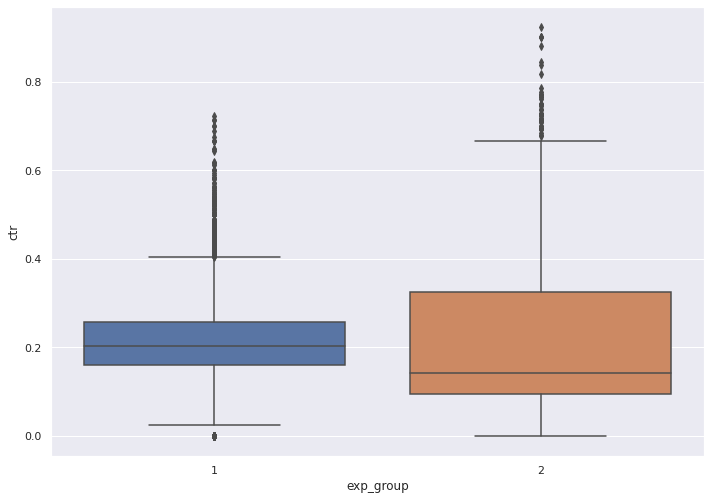

In [6]:
sns.boxplot(data=df, x="exp_group", y="ctr")

Медианное значение распределения ctr и 25-й процентиль в контрольной группе выше, зато в эксперементальной группе выше 75-й процентиль. В целом видно, что разброс значений ctr в эксперементальной группе значительно выше. Но на основании полученных боксплотов затруднительно сделать какие-либо выводы.

# Метод Левена (проверка равенства дисперсий)

Проверим являются ли дисперсии в генеральных совокупностях гомогенны. Для это используем метод Левена.
H0: дисперсии гомогенны
H1: дисперсии не являются гомогенными

In [31]:
pg.homoscedasticity(data=df, dv="ctr", group="exp_group")

,W,pval,equal_var
levene,2423.111217,0.0,False


H0 отвергаем, поскольку pvalue < 0.05. 

# Т-тест Стьюдента для показателей CTR в группах

Одним из условий получения достоверного результата с помощью ttest Стьюдента является равенство дисперсий. На предыдущем шаге мы выявили, что дисперсии не гомогенны. Так что в принцпипе этот расчет можно было бы пропустить, но мы все же посмотрим.

In [32]:
# Запускаем ttest ctr 2 и 3 групп
ttest = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)
print(f'Значение статистики равно {ttest[0]}, показатель pvalue составляет {ttest[1]}')

Значение статистики равно -0.7094392041270486, показатель pvalue составляет 0.4780623130874935


Показатель pvalue  = 0.4780623130874935 очень высокий. Значительно выше заданного порога в 0.05. Такой показатель не дает нам отвергнуть H0 гипотезу.

# ttest поверх бакетного преобразования

In [24]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = pandahouse.read_clickhouse(q, connection=connection)

In [25]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

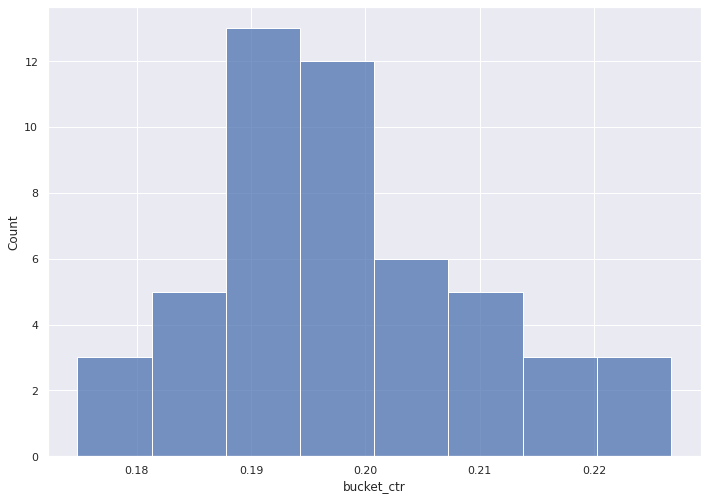

In [26]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr)

ttest поверх бакетного преобразования дал совершенно иной результат. Значение pvalue значительно ниже 0.05, что позволяет нам отвергнуть H0 о равенстве ключевой метрики. 

# Тест Манна-Уитни поверх бакетного преобразования

In [27]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=505.0, pvalue=2.859963936492646e-07)

Тест Манна-Уитни поверх бакетного преобразования дал результат аналогичный ttest поверх бакетного преобразования. Значение pvalue значительно ниже 0.05, что позволяет нам отвергнуть H0 о равенстве ключевой метрики.

# Тест Манна-Уитни

H0: ctr в группах значимо не отличаются.
H1: ctr в группах значимо отличаются

In [35]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

# Пуассоновский бутстреп

In [36]:
#функция для запуска бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [37]:
# запрос данных для проведения исследования распределения ctr в группах
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
likes2 = df[df.exp_group == 1].likes.to_numpy()
views2 = df[df.exp_group == 1].views.to_numpy()

In [38]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

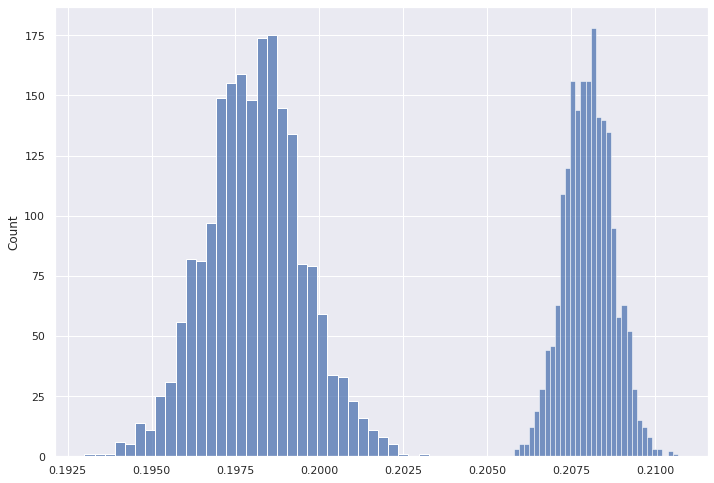

In [39]:
sns.histplot(ctr1)
sns.histplot(ctr2)

График распределения ctr в контрольной и экспериментальной группах позволяет предположить наличие стат.значимыч различий значения метрик в группах, поскольку графики не пересекаются.

<AxesSubplot:ylabel='Count'>

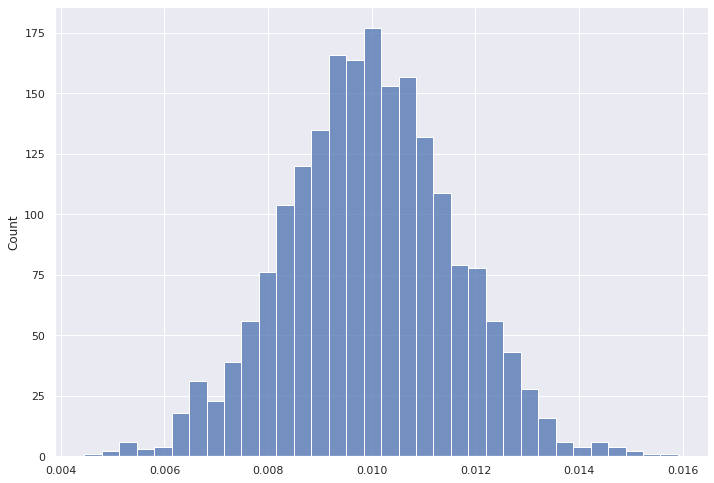

In [40]:
sns.histplot(ctr2 - ctr1)

Распределение разницы ctr  в экспериментальной и контрольной группах показывает, что предположительно ctr в экспериментальной группе выше ctr в контрольной группе.

# Почему тесты сработали так как сработали? 

Мы провели ряд тестов для определения эффекта от проведенного эксперимента. Только один тест выдал нам не стат.значимый результат - ttest Стьюдента. Предполагаю, что результат связан с ограничениями самого теста: не соблюдено условие гомогенности дисперсий, а также распределение показателя в экспериментальной группе далеко от нормального (двухмодальное с выбросами). 
Остальные тесты показали стат.значимый результат.

В рамках данного задания не выполнен t-тест на сглаженном ctr, поскольку автор данного исследования не уверен в целемообразности использования данного метода в принципе. %)

# Будем ли мы раскатывать новый алгоритм на всех новых пользователей?

В целом проведенные тесты показали положительный эффект от проведенного эксперимента. Но, хотелось бы разобраться в причине снижения медианного значения ctr в экспериментальной группе. Возможно, есть простой способ не допустить снижение медианного значения ctr при добавлении новой фичи.